In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import plot_ellipse, moca, dopioe, espra, smooth, tilt_distance_LI, robust_smooth

def deg_to_m(lat):
    R = 6371000
    rad = np.radians(lat)
    return (np.pi/180)*R*np.sqrt((np.cos(rad))**2 + 1)


### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}


theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


(np.float64(-503632.91714574234),
 np.float64(363491.5836790992),
 np.float64(-499500.0000000002),
 np.float64(477299.9999999998))

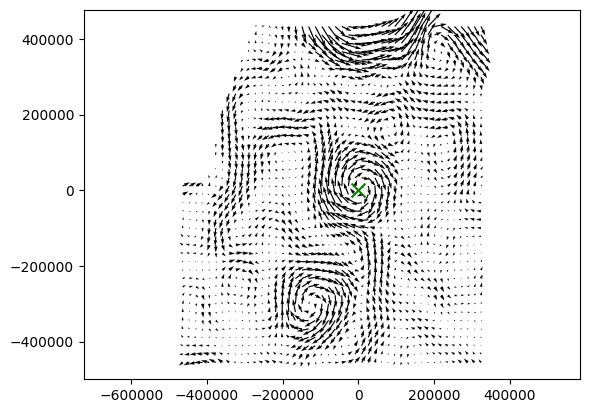

In [3]:
t_idx = 0
dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
ut, vt = dic['u'], dic['v']
plt.quiver(x_ssh, y_ssh, ut, vt)
plt.scatter(0,0, marker='x', color='g', s=100)
plt.axis('equal')


In [4]:
def dopioe_pipeliner(nxc, nyc, cyc, ut, vt, X_new, Y_new, r=30000):

    R_grid = np.hypot(nxc - X_new, nyc - Y_new)
    ic, jc = map(int, np.unravel_index(np.argmin(R_grid), R_grid.shape))

    # DOPIOE wont work if too close to boundary
    x_new = X_new[:, 0]
    y_new = Y_new[0, :]

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x_new - nxc) <= r
    x1 = x_new[x_mask]
    y1 = np.full_like(x1, y_new[jc])
    u1 = ut[x_mask, jc]
    v1 = vt[x_mask, jc]
    
    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y_new - nyc) <= r
    y2 = y_new[y_mask]
    x2 = np.full_like(y2, x_new[ic])
    u2 = ut[ic, y_mask]
    v2 = vt[ic, y_mask]
    
    xc, yc, w, Q, Rc, psi0, A = dopioe(x1, y1, u1, v1, x2, y2, u2, v2, A_flag=True, plot_flag=False)#, Rc_tol_factor=5)
    
    cyc_DOPIOE = 'CE' if w < 0 else 'AE'
    
    if (cyc_DOPIOE != cyc) or (np.hypot(nxc - xc, nyc - yc) > 50000):
        return np.nan, np.nan, np.nan, np.array([[np.nan, np.nan],
                                                [np.nan, np.nan]]), np.nan, np.nan
    
    return xc, yc, w, Q, Rc, psi0, A


In [5]:
xc_pre, yc_pre = 0, 0
df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Time'])
for t_idx in range(len(dic_ssh_data)):
    dic = dic_ssh_data[list(dic_ssh_data.keys())[t_idx]]
    ut, vt = dic['u'], dic['v']
    xc, yc, w, Q, Rc, psi0, A = dopioe_pipeliner(xc_pre, yc_pre, 'CE', ut.T, vt.T, x_ssh.T, y_ssh.T, r=60000)
    df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q,
                               'Rc': Rc, 'psi0': psi0, 'A': A, 'Time': list(dic_ssh_data.keys())[t_idx]}
    if np.isnan(xc):
        break
    xc_pre, yc_pre = xc, yc
df_res


,xc,yc,w,Q,Rc,psi0,A,Time
0,4567.210026,4265.250534,-0.000034,"[[1.2164927309794968, 0.013788956995872856], [...",78227.028929,51248.057495,-0.000008,2023-10-18 18:00:00
1,3743.382976,4773.693922,-0.000033,"[[1.2270286921192426, 0.01358943308006459], [0...",74796.809835,45466.143095,-0.000008,2023-10-19 18:00:00
2,4341.456773,3920.767193,-0.000036,"[[1.220849094331472, 0.040694009867264534], [0...",75404.047676,49740.945924,-0.000009,2023-10-20 18:00:00
3,2823.524501,5407.131956,-0.000034,"[[1.2095030981210038, -0.0031489094427619288],...",72896.372683,44784.429878,-0.000008,2023-10-21 18:00:00
4,1928.931823,5625.783231,-0.000033,"[[1.2136274844249624, 0.020911762623818452], [...",65748.589159,34563.042011,-0.000008,2023-10-22 18:00:00
...,...,...,...,...,...,...,...,...
116,-322089.176367,84166.698392,-0.000018,"[[1.4782610253135677, -0.11151454845989732], [...",58151.293711,14325.624934,-0.000004,2024-02-07 06:00:00
117,-318525.407480,80515.721035,-0.000018,"[[1.4561398894005124, -0.1544262416471098], [-...",50932.105422,10845.584438,-0.000004,2024-02-08 06:00:00
118,-318258.255915,78476.495239,-0.000018,"[[1.5079742854651477, -0.1527337557632319], [-...",81302.323259,27171.580519,-0.000004,2024-02-09 06:00:00
119,-316019.852651,78683.803592,-0.000017,"[[1.5996074877728637, -0.15024593937669123], [...",79759.538317,24758.590448,-0.000004,2024-02-10 06:00:00


(np.float64(-342408.63974640134),
 np.float64(21089.869538722774),
 np.float64(-9989.731731845775),
 np.float64(166292.12929271552))

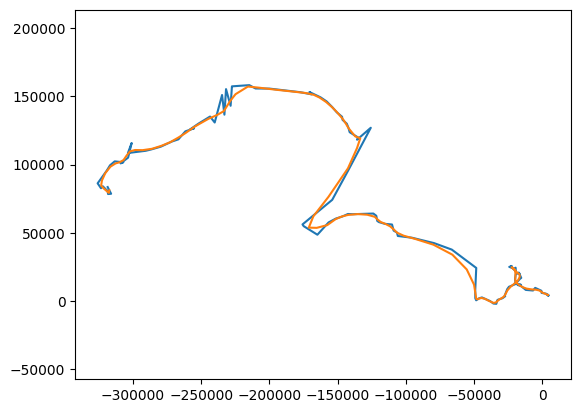

In [6]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


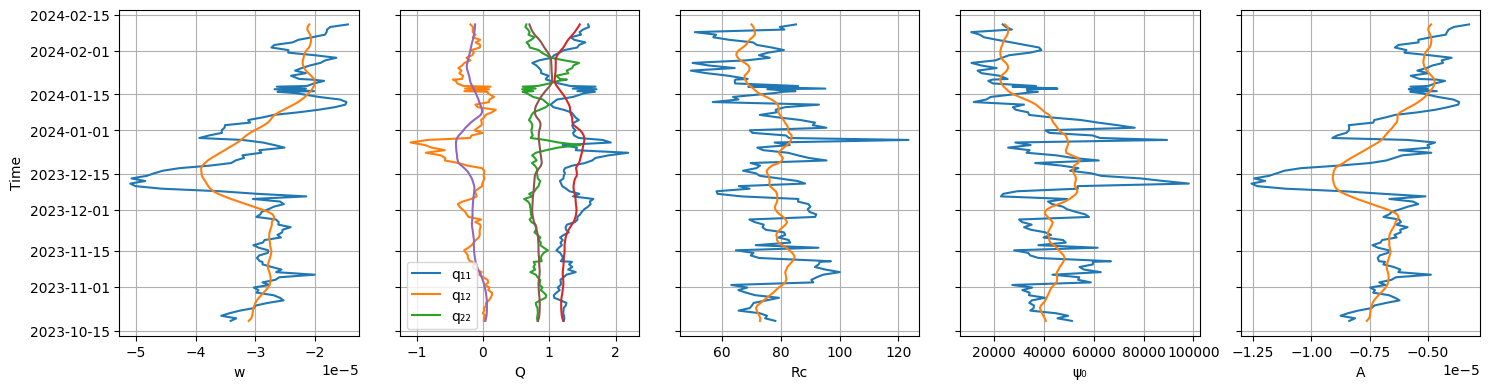

In [7]:
wdw = 20
df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Time)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


Text(0.5, 1.0, '2023-11-07 18:00:00')

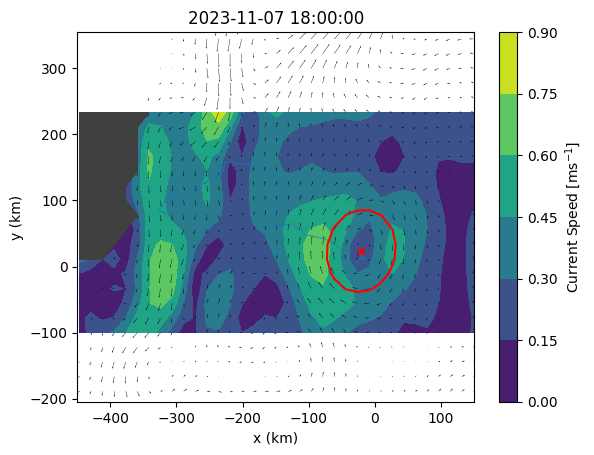

In [13]:
t_idx = 20
data = df_res.iloc[t_idx]

closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, np.hypot(ut_mask, vt_mask))
plt.colorbar(label=r'Current Speed [ms$^{-1}$]')
plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
plt.plot(df_res.xc/1e3, df_res.yc/1e3, lw=.5)

plt.scatter(data.xc/1e3, data.yc/1e3, marker='x', color='r', s=25, zorder=3)

dx_ell, dy_ell = x_ssh/1e3 - data.xc/1e3, y_ssh/1e3 - data.yc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
            colors='r', zorder=3)

mask_nan = np.isnan(ut)
mask_expand = binary_dilation(mask_nan, iterations=1)
land_mask = np.where(mask_expand & mask, 0, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')

plt.xlabel('x (km)'); plt.ylabel('y (km)')
plt.axis('equal')
plt.xlim(-450, 150); plt.ylim(-100, 250)
plt.title(f'{list(dic_ssh_data.keys())[t_idx]}')



In [9]:
# # MOVIE
# for t_idx in range(len(dic_ssh_data)):
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
#     plt.plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5)
#     data = df_res.iloc[t_idx]
#     plt.scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
    
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     plt.contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2],
#                 colors='r', zorder=3)
    
#     land_mask = np.zeros_like(ut)
#     land_mask = np.where(np.isnan(ut), 0, np.nan)
#     plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')
    
#     plt.xlabel('x (km)'); plt.ylabel('y (km)')
#     plt.axis('equal')
#     plt.xlim(-450, 150); plt.ylim(-100, 250)
#     plt.title(f'{list(dic_ssh_data.keys())[t_idx]}')
        
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/DOPIOE_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()
    

In [10]:
x = np.linspace(-450000, 150000, 101)
y = np.linspace(-100000, 250000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 


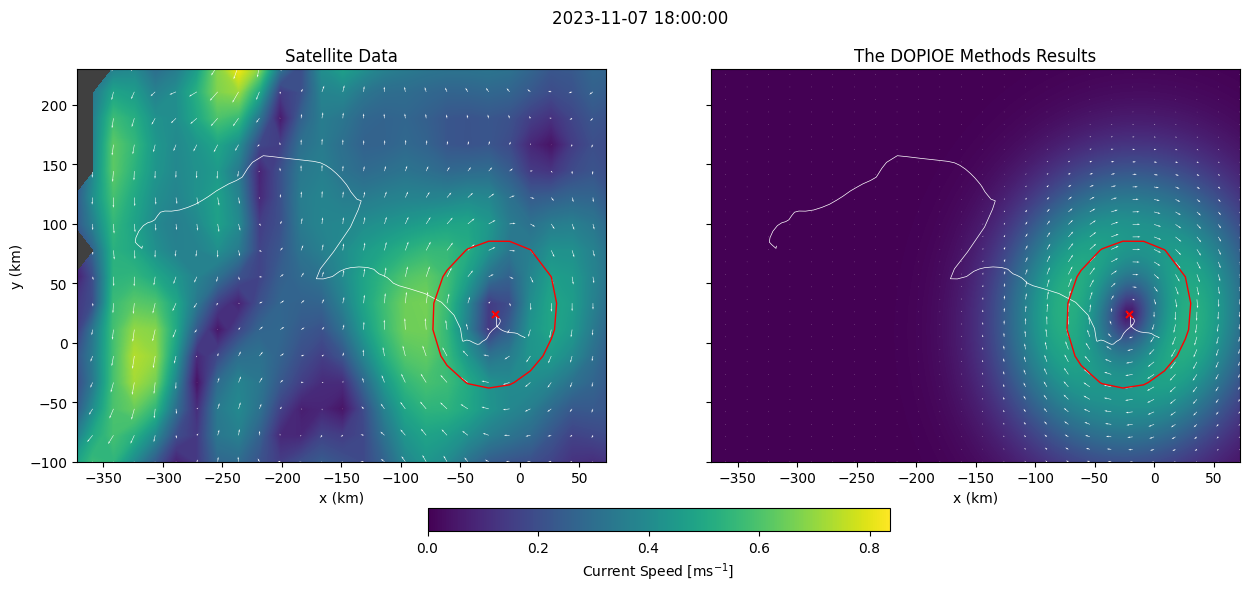

In [14]:
t_idx = 20
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

data = df_res.iloc[t_idx]

# data & masks
closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
spd1 = np.hypot(ut_mask, vt_mask)

u, v = U[:,:,t_idx], V[:,:,t_idx]
spd2 = np.hypot(u, v)

# shared colour scale: force 0 baseline, use combined max, and FIX levels
vmin = 0.0
vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
cmap = 'viridis'
levels = np.linspace(vmin, vmax, 256)  # identical bins for both
norm = plt.Normalize(vmin, vmax)

# --- plot 1 ---
cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
# land overlay
mask_nan = np.isnan(ut)
mask_expand = binary_dilation(mask_nan, iterations=1)
land_mask = np.where(mask_expand & mask, 0, np.nan)
axs[0].contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')

# --- plot 2 ---
cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
spac = 3
axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
              u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The DOPIOE Methods Results')
axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)

# shared colourbar reflects exactly those shared levels
cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label(r'Current Speed [ms$^{-1}$]')
cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))
# plt.tight_layout()
fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
plt.show()



In [15]:
# # MOVIE
# for t_idx in range(len(df_res)):
#     fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
#     data = df_res.iloc[t_idx]
    
#     # data & masks
#     closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
#     ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
#     mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
#     ut_mask, vt_mask = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)
#     spd1 = np.hypot(ut_mask, vt_mask)
    
#     u, v = U[:,:,t_idx], V[:,:,t_idx]
#     spd2 = np.hypot(u, v)
    
#     # shared colour scale: force 0 baseline, use combined max, and FIX levels
#     vmin = 0.0
#     # vmax = np.nanmax(np.concatenate([spd1.ravel(), spd2.ravel()]))
#     vmax = 1.0
#     cmap = 'viridis'
#     levels = np.linspace(vmin, vmax, 256)  # identical bins for both
#     norm = plt.Normalize(vmin, vmax)
    
#     # --- plot 1 ---
#     cf1 = axs[0].contourf(x_ssh/1e3, y_ssh/1e3, spd1, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     axs[0].quiver(x_ssh/1e3, y_ssh/1e3, ut_mask, vt_mask, width=.001, scale=30, color='w')
#     axs[0].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     dx_ell, dy_ell = x_ssh/1e3 - data.sxc/1e3, y_ssh/1e3 - data.syc/1e3
#     rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
#     axs[0].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[0].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     # land overlay
#     mask_nan = np.isnan(ut)
#     mask_expand = binary_dilation(mask_nan, iterations=1)
#     land_mask = np.where(mask_expand & mask, 0, np.nan)
#     axs[0].contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')
#     axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')
#     axs[0].set_xlim(-450, 150); axs[0].set_ylim(-100, 230); axs[0].set_title('Satellite Data')
    
#     # --- plot 2 ---
#     cf2 = axs[1].contourf(X/1e3, Y/1e3, spd2, levels=levels, cmap=cmap, norm=norm, extend='neither')
#     spac = 3
#     axs[1].quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
#                   u[::spac,::spac], v[::spac,::spac], width=.001, scale=30, color='w')
#     axs[1].plot(df_res.sxc/1e3, df_res.syc/1e3, lw=.5, color='w')
#     axs[1].scatter(data.sxc/1e3, data.syc/1e3, marker='x', color='r', s=25, zorder=3)
#     axs[1].contour(x_ssh/1e3, y_ssh/1e3, rho2_ell, levels=[(data.sRc/1e3)**2/2], colors='r', zorder=3, linewidths=1)
#     axs[1].axis('equal'); axs[1].set_xlabel('x (km)'); axs[1].set_title('The DOPIOE Methods Results')
#     axs[1].set_xlim(-450, 150); axs[1].set_ylim(-100, 230)
    
#     # shared colourbar reflects exactly those shared levels
#     cbar = fig.colorbar(cf2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1)
#     cbar.set_label(r'Current Speed [ms$^{-1}$]')
#     cbar.set_ticks(np.linspace(vmin, round(vmax, 1), 5))

#     fig.suptitle(f'{list(dic_ssh_data.keys())[t_idx]}')
#     plt.savefig(f'/srv/scratch/z5297792/ESP_Paper_Data/DOPIOE_IMOS_Data/tracking_images/frame_{t_idx:03d}.png', dpi=300, bbox_inches='tight')
#     plt.close()

